In [10]:
import numpy as np
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
import folium
import vaex
import pandas as pd
from math import pi, cos, sin
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import vaex.ml
import vaex.ml.cluster

Preprocessing Dataframes for clustering
Clustering triptypes: Duration, Distance, start time, locations 
Clustering Companies: Companies, duration, locations, distance, fares
Clustering Customers: Locations, Tips, Payment types

## Data Preperation

In [94]:
#loading prepared data
df_original = vaex.open('./data/trips_prepared.hdf5')


In [95]:
#make important changes to prepare for clustering
df = df_original.copy()

#add month, weekday, and hour columns
df['month'] = df.trip_start_timestamp.dt.month
df['weekday'] = df.trip_start_timestamp.dt.dayofweek
df['hour'] = df.trip_start_timestamp.dt.hour

df_location = df.copy()



In [71]:
#hour and day need to be recalculated as circular features in order to ensure the correct distances between each hour/day

def circular( dataframe, feature, name, n):
    dataframe[name + '_sin'] = feature.apply(lambda x: sin(2*pi*(x/n)))
    dataframe[name + '_cos'] = feature.apply(lambda x: cos(2*pi*(x/n)))

circular(df, df['weekday'], 'day', 7)
circular(df, df['hour'], 'hour', 24)




In [5]:
#dropping unneccessary columns
df.drop(columns = ['trip_id', 'taxi_id','trip_start_timestamp', 'trip_end_timestamp', 'pickup_census_tract', 'dropoff_census_tract', 'pickup_community_area', 'dropoff_community_area', 'tolls', 'extras', 'trip_total',  'trip_start_hour',    'trip_end_hour',    'trip_start_4h_period',    'trip_end_4h_period'  ], inplace=True)
df.head(1)

#,trip_seconds,trip_miles,fare,tips,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,month,weekday,hour,day_sin,day_cos,hour_sin,hour_cos
0,240,1.3,6.25,0,Cash,Taxi Affiliation Services,41.881,-87.6327,41.8853,-87.6572,1,6,0,-0.781831,0.62349,0,1


In [6]:
#look at data for potential outliers
df.describe()

,trip_seconds,trip_miles,fare,tips,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,month,weekday,hour,day_sin,day_cos,hour_sin,hour_cos
data_type,float64,float64,float64,float64,string,string,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64
count,10980710,10980710,10980710,10980710,10980710,10980710,10980710,10980710,10980710,10980710,10980710,10980710,10980710,10980710,10980710,10980710,10980710
NA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
mean,806.761220995728,3.3948594872244557,12.7452870807079,1.6908211026424875,--,--,41.89235199932879,-87.64990817598304,41.89287131070189,-87.64496774761975,6.444176651600853,2.8719716666772914,14.082882709770134,0.07545092781209432,-0.09543744705720335,-0.28615116879368785,-0.22720410346370748
std,917.378096,5.522685,26.331906,2.749389,--,--,0.030478,0.068538,0.027739,0.055912,3.322701,1.845464,5.520297,0.692758,0.710834,0.651666,0.664701
min,1.0,0.01,0.0,0.0,--,--,41.715761,-87.90304,41.683404,-87.90304,1,0,0,-0.974928,-0.900969,-1.0,-1.0
max,86374.0,1567.2,9280.82,311.18,--,--,42.021224,-87.573952,42.021224,-87.531386,12,6,23,0.974928,1.0,1.0,1.0


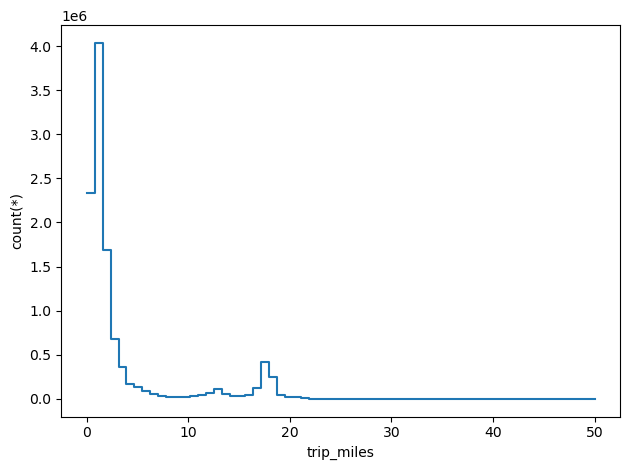

In [7]:
#huge outliers in distance
df.viz.histogram(df.trip_miles, limits=[0,50])

In [38]:
#95 percent of data lies between 0.2 miles and 18.11 miles
df.limits_percentage('trip_miles', 95)

array([ 0.19910185, 18.10967458])

In [39]:
#fewer than 60.000 rides had been longer than 20 miles therfore we discard those in order to avoid outlier bias
df.select(df.trip_miles > 20)
print(len(df.evaluate(df.trip_miles, selection=True)))
df= df[df['trip_miles'] < 20]
df['weekend'] = df['weekday'].apply(lambda x: 1 if x > 4 else 0)
df.head(1)

55520


#,trip_seconds,trip_miles,fare,tips,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,month,weekday,hour,day_sin,day_cos,hour_sin,hour_cos,weekend
0,240,1.3,6.25,0,Cash,Taxi Affiliation Services,41.881,-87.6327,41.8853,-87.6572,1,6,0,-0.781831,0.62349,0,1,1


In [40]:
#scaling method for variables that need scaling
scaler = StandardScaler()

def scaling(data):
    scaler.fit(data)
    data_scaled = scaler.transform(data)
    df_data_scaled = pd.DataFrame(data_scaled, columns = data.get_column_names())
    return data_scaled, df_data_scaled

In [41]:
#choose number of clusters for k-means

def k_optimal(data, k_max):
    clusters = []
    losses = []
    for k in range(k_max):
        model= MiniBatchKMeans(n_clusters=k+1,random_state=42,init="k-means++") 
        model.fit(data)
        clusters.append(k+1)
        losses.append(model.inertia_)
    plt.plot(clusters, losses)
        #plt.xlim([2,10])
    plt.ylabel("Loss")
    plt.xlabel("Number of clusters")
    plt.show()

### CLUSTERING TRIP TYPES

In [42]:
#preparing dataframe
features = ['trip_seconds','fare', 'tips','payment_type', 'company', 'pickup_centroid_latitude', 'pickup_centroid_longitude','dropoff_centroid_latitude', 'dropoff_centroid_longitude']
df_cluster_one = df.drop(columns = features)
df_cluster_one.head(1)


#,trip_miles,month,weekday,hour,day_sin,day_cos,hour_sin,hour_cos,weekend
0,1.3,1,6,0,-0.781831,0.62349,0,1,1


In [43]:
#scaling variables that need scaling
features = ['month', 'weekday', 'hour', 'weekend']

df_cluster_one_scaling = df_cluster_one.drop(columns = features)

cluster_one_scaled, df_cluster_one_scaled =  scaling(df_cluster_one_scaling)

df_cluster_one_scaled = vaex.from_pandas(df_cluster_one_scaled)

In [54]:
df_cluster_one_scaled.head(1)

#,trip_miles,day_sin,day_cos,hour_sin,hour_cos
0,-0.39838,-1.23707,1.0122,0.439968,1.84316


In [53]:
test_df = df_cluster_one_scaled.copy()
df_dummy = df_cluster_one.drop(columns = ['hour_sin','hour_cos','day_sin', 'day_cos','hour', 'weekend','weekday', 'month', 'trip_miles'])
test_df = test_df.join(df_dummy, allow_duplication=True)
test_df.head(1)

#,trip_miles,day_sin,day_cos,hour_sin,hour_cos
0,-0.39838,-1.23707,1.0122,0.439968,1.84316


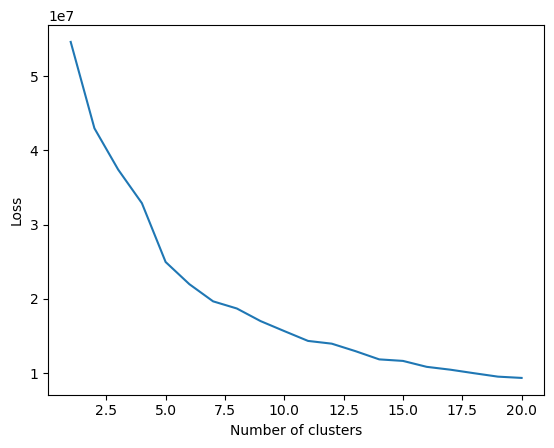

In [46]:
#choose number of clusters for k-means

k_optimal(test_df, 20)

In [47]:
#test vaex kmeans
features = ['trip_miles', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos']
cls = vaex.ml.cluster.KMeans(n_clusters = 5, features = features, max_iter= 10)
cls.fit(test_df)
df_neu = cls.transform(test_df)

#,trip_miles,day_sin,day_cos,hour_sin,hour_cos,prediction_kmeans
0,-0.39838,-1.23707,1.0122,0.439968,1.84316,4
1,-0.580949,-1.23707,1.0122,0.439968,1.84316,4
2,-0.479522,-1.23707,1.0122,0.439968,1.84316,4
3,-0.459236,-1.23707,1.0122,0.439968,1.84316,4
4,-0.560663,-1.23707,1.0122,0.439968,1.84316,4
5,0.0276138,-1.23707,1.0122,0.439968,1.84316,4
6,0.534749,-1.23707,1.0122,0.439968,1.84316,4
7,-0.641805,-1.23707,1.0122,0.439968,1.84316,4
8,-0.580949,-1.23707,1.0122,0.439968,1.84316,4
9,-0.520093,-1.23707,1.0122,0.439968,1.84316,4


In [58]:
# refit algorithm full data

means = MiniBatchKMeans(n_clusters=5, random_state=42,init="k-means++")
means.fit(test_df)

numbers = ['one', 'two', 'three', 'four', 'five', 'six']
#add cluster lables to the dataset
test_df["cluster"] = means.predict(test_df)
test_df["cluster"] = test_df["cluster"].apply(lambda x: numbers[x])

df_dummy = df_cluster_one.drop(columns = ['trip_miles', 'hour_sin','hour_cos', 'day_cos', 'day_sin'])
test_df = test_df.join(df_dummy, allow_duplication=True)


In [ ]:

violin_plots, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20,15))


sns.violinplot(ax = axes[0, 0], x=test_df.cluster.values, y=test_df.weekend.values)
sns.violinplot(ax = axes[0, 1], x=test_df.cluster.values, y=test_df.weekday.values)
sns.violinplot(ax = axes[1, 0], x=test_df.cluster.values, y=test_df.hour.values)
sns.violinplot(ax = axes[1, 1], x=test_df.cluster.values, y=test_df.trip_miles.values)
sns.violinplot(ax = axes[2, 0], x=test_df.cluster.values, y=test_df.month.values)

axes[0, 0].set_title('Weekend'), axes[0, 1].set_title('Weekday'), axes[1, 0].set_title('Hour'), axes[1, 1].set_title('Distance'), axes[2,0].set_title('Month')


violin_plots.tight_layout()
plt.show()

## Clustering Locations

In [ ]:
df_location

In [127]:
df_location_start = df_location[['pickup_census_tract', 'trip_start_hour', 'weekday']]
df_location_start = df_location_start[df_location_start['weekday'] < 5]
df_location_start.drop(columns = ['weekday'], inplace = True)
df_location_start_pd = pd.DataFrame(df_location_start)
df_location_start_pd.rename(columns = {0: 'pickup_census_tract', 1: 'trip_start_hour'}, inplace = True)
df_location_start_pd.loc[:,"hour"] = df_location_start_pd['trip_start_hour'].apply(lambda x: np.trunc(x))
df_location_start_pd = df_location_start_pd.groupby(['trip_start_hour', 'pickup_census_tract']).size().unstack()
df_location_start_pd = df_location_start_pd.fillna(0) #fill NaN entrys with 0
df_location_start_pd



pickup_census_tract,1.703101e+10,1.703101e+10,1.703101e+10,1.703101e+10,1.703101e+10,1.703101e+10,1.703101e+10,1.703101e+10,1.703101e+10,1.703101e+10,...,1.703184e+10,1.703184e+10,1.703184e+10,1.703184e+10,1.703184e+10,1.703184e+10,1.703184e+10,1.703184e+10,1.703198e+10,1.703198e+10
trip_start_hour,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,282.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,9908.0,3307.0
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,133.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3794.0,1440.0
2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,...,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1058.0,438.0
3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,323.0,73.0
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,555.0,23.0
5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1872.0,46.0
6.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,...,138.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4877.0,743.0
7.0,0.0,8.0,8.0,1.0,2.0,3.0,6.0,4.0,0.0,2.0,...,358.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,9700.0,4010.0
8.0,1.0,0.0,0.0,2.0,3.0,4.0,1.0,3.0,0.0,4.0,...,606.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,18073.0,6936.0


In [131]:
df_location_start = vaex.from_pandas(df_location_start_pd)
df_location_start

#,17031010100.0,17031010201.0,17031010202.0,17031010300.0,17031010400.0,17031010501.0,17031010502.0,17031010503.0,17031010600.0,17031010702.0,17031020100.0,17031020200.0,17031020301.0,17031020302.0,17031020400.0,17031020500.0,17031020601.0,17031020602.0,17031020701.0,17031020702.0,17031020801.0,17031020802.0,17031020901.0,17031020902.0,17031030101.0,17031030102.0,17031030103.0,17031030104.0,17031030200.0,17031030300.0,17031030400.0,17031030500.0,17031030601.0,17031030603.0,17031030604.0,17031030701.0,17031030702.0,17031030703.0,17031030706.0,17031030800.0,17031030900.0,17031031000.0,17031031100.0,17031031200.0,17031031300.0,17031031400.0,17031031501.0,17031031502.0,17031031700.0,17031031800.0,17031031900.0,17031032100.0,17031040100.0,17031040201.0,17031040202.0,17031040300.0,17031040401.0,17031040402.0,17031040600.0,17031040700.0,17031040800.0,17031040900.0,17031050100.0,17031050200.0,17031050300.0,17031050500.0,17031050600.0,17031050700.0,17031050800.0,17031050900.0,17031051100.0,17031051200.0,17031051300.0,17031051400.0,17031060100.0,17031060200.0,17031060300.0,17031060400.0,17031060500.0,17031060800.0,17031060900.0,17031061000.0,17031061100.0,17031061200.0,17031061500.0,17031061800.0,17031061901.0,17031061902.0,17031062000.0,17031062100.0,17031062200.0,17031062300.0,17031062400.0,17031062500.0,17031062600.0,17031062700.0,17031062800.0,17031062900.0,17031063000.0,17031063100.0,...,17031310300.0,17031310400.0,17031310600.0,17031310800.0,17031320100.0,17031320400.0,17031320600.0,17031330100.0,17031330200.0,17031340500.0,17031340600.0,17031350100.0,17031350400.0,17031351000.0,17031380100.0,17031380200.0,17031390300.0,17031390600.0,17031390700.0,17031410100.0,17031410500.0,17031410600.0,17031410700.0,17031410800.0,17031410900.0,17031411000.0,17031411100.0,17031411200.0,17031420200.0,17031420300.0,17031430101.0,17031440300.0,17031450300.0,17031480300.0,17031490500.0,17031580100.0,17031600600.0,17031661100.0,17031681000.0,17031760801.0,17031770602.0,17031810400.0,17031830600.0,17031830700.0,17031830800.0,17031830900.0,17031831000.0,17031831100.0,17031831800.0,17031831900.0,17031832000.0,17031832100.0,17031832200.0,17031832300.0,17031832400.0,17031832500.0,17031832600.0,17031832900.0,17031833000.0,17031833100.0,17031833300.0,17031835200.0,17031835900.0,17031836200.0,17031836400.0,17031836700.0,17031837000.0,17031837100.0,17031837800.0,17031838000.0,17031838100.0,17031838200.0,17031838300.0,17031838600.0,17031839000.0,17031839100.0,17031839200.0,17031839500.0,17031839700.0,17031840000.0,17031840200.0,17031840300.0,17031840400.0,17031840700.0,17031841000.0,17031841100.0,17031841300.0,17031841900.0,17031842000.0,17031842200.0,17031842300.0,17031842400.0,17031842900.0,17031843000.0,17031843100.0,17031843200.0,17031843300.0,17031843700.0,17031980000.0,17031980100.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,12.0,3.0,142.0,61.0,4.0,8.0,0.0,0.0,16.0,0.0,0.0,19.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,1.0,12.0,30.0,0.0,69.0,347.0,521.0,80.0,50.0,39.0,6.0,3.0,359.0,1026.0,308.0,7.0,3.0,0.0,0.0,4.0,10.0,66.0,204.0,69.0,...,0.0,0.0,5.0,0.0,5327.0,3102.0,1838.0,783.0,8.0,9.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9.0,98.0,0.0,2.0,18.0,1.0,0.0,39.0,1201.0,28.0,1.0,5.0,0.0,3.0,105.0,0.0,4980.0,207.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,11.0,462.0,2.0,5.0,0.0,64.0,8388.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,229.0,0.0,0.0,102.0,0.0,505.0,282.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,9908.0,3307
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,6.0,2.0,64.0,38.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.

In [132]:
location_start_scaled, df_location_start_scaled = scaling(df_location_start)

In [133]:
location_start_scaled_trans = location_start_scaled.transpose()
df_location_start_scaled_trans = df_location_start_scaled.transpose()

In [139]:

# refit algorithm full data

means = MiniBatchKMeans(n_clusters=4, random_state=42,init="k-means++")
means.fit(location_start_scaled_trans)

numbers = ['one', 'two', 'three', 'four', 'five', 'six']
#add cluster lables to the dataset
df_location_start_scaled_trans["cluster"] = means.predict(location_start_scaled_trans)
df_location_start_scaled_trans["cluster"] = df_location_start_scaled_trans["cluster"].apply(lambda x: numbers[x])



In [145]:
#sort stations into respective cluster dataframes
df_stations_one = df_location_start_scaled_trans.loc[df_location_start_scaled_trans['cluster'] == 'one']
df_stations_two = df_location_start_scaled_trans.loc[df_location_start_scaled_trans['cluster'] == 'two']
df_stations_three = df_location_start_scaled_trans.loc[df_location_start_scaled_trans['cluster'] == 'three']
df_stations_four = df_location_start_scaled_trans.loc[df_location_start_scaled_trans['cluster'] == 'four']

#drop the cluster column as its not needed anymore
df_stations_one = df_stations_one.drop(['cluster'], axis = 1)
df_stations_two = df_stations_two.drop(['cluster'], axis = 1)
df_stations_three = df_stations_three.drop(['cluster'], axis = 1)
df_stations_four = df_stations_four.drop(['cluster'], axis = 1)

#transpose and calculate average over every hour of the day 
df_stations_one = df_stations_one.transpose()
df_stations_two = df_stations_two.transpose()
df_stations_three = df_stations_three.transpose()
df_stations_three = df_stations_four.transpose()

df_stations_one['average'] = df_stations_one.mean(numeric_only = True, axis = 1)
df_stations_two['average'] = df_stations_two.mean(numeric_only = True, axis = 1)
df_stations_three['average'] = df_stations_three.mean(numeric_only = True, axis = 1)
df_stations_four['average'] = df_stations_four.mean(numeric_only = True, axis = 1)

(None,
 Text(0.5, 1.0, 'Cluster 3: Work/University\nArea'),
 Text(784.1881313131312, 0.5, 'Trips'),
 Text(0.5, 47.7222222222222, 'Start Hour'))

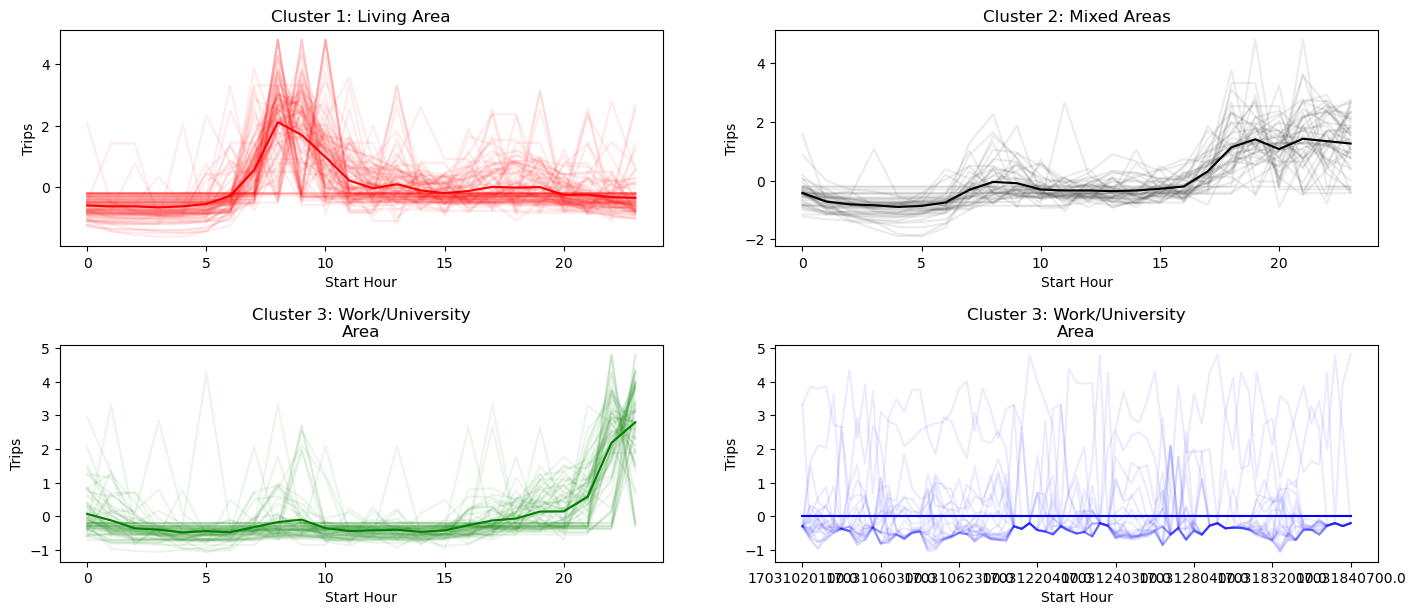

In [147]:
#plot the results
fig, ax = plt.subplots(nrows = 2, ncols = 2,figsize=(15,7))
fig.tight_layout(pad = 5)

df_stations_one.plot(ax=ax[0,0],color='red', alpha=0.08)
df_stations_one["average"].plot(ax=ax[0,0],color='red', alpha=1)
ax[0,0].get_legend().remove(), ax[0,0].set_title('Cluster 1: Living Area'), ax[0,0].set_ylabel('Trips'), ax[0,0].set_xlabel('Start Hour')

df_stations_two.plot(ax=ax[0,1],color='black', alpha=0.08)
df_stations_two["average"].plot(ax=ax[0,1],color='black', alpha=1)
ax[0,1].get_legend().remove(), ax[0,1].set_title('Cluster 2: Mixed Areas'), ax[0,1].set_ylabel('Trips'), ax[0,1].set_xlabel('Start Hour')

df_stations_three.plot(ax=ax[1,0],color='green', alpha=0.08)
df_stations_three["average"].plot(ax=ax[1,0],color='green', alpha=1)
ax[1,0].get_legend().remove(), ax[1,0].set_title('Cluster 3: Work/University\nArea'), ax[1,0].set_ylabel('Trips'), ax[1,0].set_xlabel('Start Hour')

df_stations_four.plot(ax=ax[1,1],color='blue', alpha=0.08)
df_stations_four["average"].plot(ax=ax[1,1],color='blue', alpha=1)
ax[1,1].get_legend().remove(), ax[1,1].set_title('Cluster 3: Work/University\nArea'), ax[1,1].set_ylabel('Trips'), ax[1,1].set_xlabel('Start Hour')